In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
import corner

r = pickle.load(open('data/munged_data.p', 'rb'))

In [24]:
datasets = r['datasets']
rv_datasets = r['rv_datasets']
transit_times_est = r['transit_times_est']
transit_inds_est = r['transit_inds_est']
period_est = r['period_est']
t0_est = r['t0_est']
dur_est = r['dur_est']

M_star = 0.913, 0.047
R_star = 0.939, 0.022
msini = 90
depth_est = 0.04

## Plot data

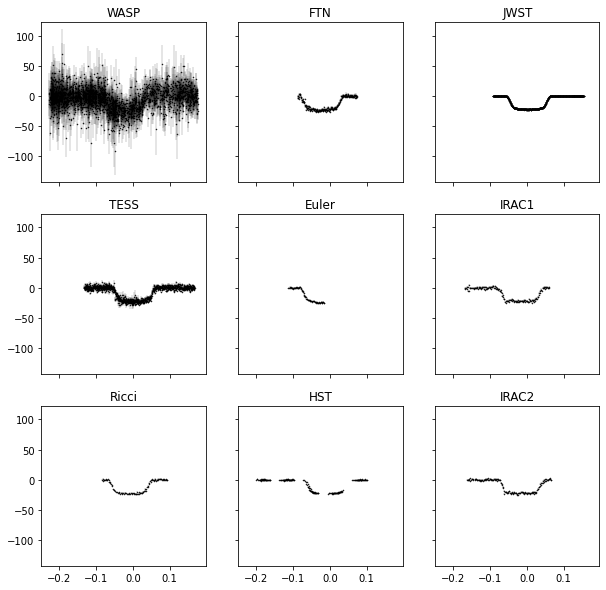

In [25]:
fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=True, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    ax[idx, jdx].errorbar(ph, y, yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1)
    ax[idx, jdx].set(title=name)

Text(0.5, 1.0, 'RV Data')

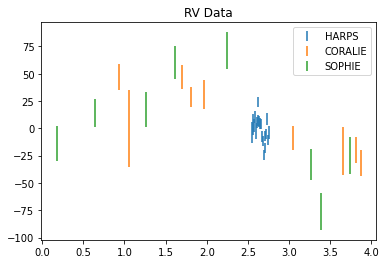

In [26]:
plt.figure()
for n, (name, (x, y, yerr)) in enumerate(rv_datasets.items()):
    plt.errorbar(x % period_est, y, yerr, ls='', label=name)
plt.legend()
plt.title("RV Data")

## Set up the model.

In [27]:
with pm.Model() as model:
    
    # Star parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
    m_star = BoundedNormal(
        "m_star", mu=M_star[0], sd=M_star[1]
    )
    r_star = BoundedNormal(
        "r_star", mu=R_star[0], sd=R_star[1]
    )
    b = pm.Uniform("b", lower=0, upper=1, shape=1)
    ld_arg = 1 - tt.sqrt(1 - b**2)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=-0.05, upper=0.05)
    transit_times = [BoundedNormal("tts",
            mu=0,
            sd=0.02,
            shape=len(transit_times_est),
        ) + transit_times_est]
        
    orbit = xo.orbits.TTVOrbit(
            r_star=r_star,
            m_star=m_star,
            b=b,
            transit_times=transit_times,
            transit_inds=[transit_inds_est]
        )
    
    parameters = dict()
    lc_models = dict()
    for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
        # We define the per-instrument parameters in a submodel so that we
        # don't have to prefix the names manually
        with pm.Model(name=name, model=model):
            # The flux zero point
            mean = pm.Normal("mean", mu=0.0, sigma=10.0)
            u_star = xo.QuadLimbDark("u")
            star = xo.LimbDarkLightCurve(u_star)
            
            # The radius ratio
            log_approx_depth = pm.Normal(
                "log_approx_depth", mu=np.log(depth_est), sigma=10
            )
            ld = 1 - u_star[0] * ld_arg - u_star[1] * ld_arg**2
            ror = pm.Deterministic(
                "ror", tt.exp(0.5 * log_approx_depth) / tt.sqrt(ld)
            )
            r_pl = pm.Deterministic("r_pl", ror * r_star)
            
            # Noise parameters
            med_yerr = np.median(yerr)
            std = np.std(y)
            # This doesn't seem right...
            sigma = pm.InverseGamma(
                "sigma",
                testval=med_yerr,
                **pmx.estimate_inverse_gamma_parameters(
                    lower=med_yerr, upper=0.5 * std
                ),
            )
            # Keep track of the parameters for optimization
            parameters[name] = [mean, u_star, ror]
            parameters[f"{name}_noise"] = [sigma]
            
         # The light curve model
        def lc_model(mean, star, ror, texp, t):
            return mean + (1e3 * tt.sum(
                star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp),
                axis=-1,
            ))

        light_curve = lc_model(mean, star, ror, texp, x)
        lc_models[name] = light_curve
        pm.Normal(f"{name}_obs", observed=y, sd=(yerr**2 + sigma**2)**0.5, mu=light_curve)
    
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [*transit_times, m_star, r_star, b])
    for name in datasets:
        map_soln = pmx.optimize(map_soln, parameters[name])
    map_soln = pmx.optimize(map_soln, [*[parameters[f"{name}_noise"][0] for name in datasets], *transit_times, m_star, r_star, b])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [b, r_star, m_star, tts]


message: Desired error not necessarily achieved due to precision loss.
logp: -218405.16292065126 -> -21168.917410227114
optimizing logp for variables: [WASP_log_approx_depth, WASP_u, b, WASP_mean]


message: Optimization terminated successfully.
logp: -21168.917410227114 -> -21167.48486594205
optimizing logp for variables: [TESS_log_approx_depth, TESS_u, b, TESS_mean]


message: Optimization terminated successfully.
logp: -21167.48486594205 -> -21152.223661695098
optimizing logp for variables: [Ricci_log_approx_depth, Ricci_u, b, Ricci_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21152.223661695098 -> -21145.164330295236
optimizing logp for variables: [FTN_log_approx_depth, FTN_u, b, FTN_mean]


message: Optimization terminated successfully.
logp: -21145.164330295236 -> -21140.298955139908
optimizing logp for variables: [Euler_log_approx_depth, Euler_u, b, Euler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21140.298955139908 -> -21122.486999664583
optimizing logp for variables: [HST_log_approx_depth, HST_u, b, HST_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21122.486999664583 -> -17820.81003056249
optimizing logp for variables: [JWST_log_approx_depth, JWST_u, b, JWST_mean]


message: Optimization terminated successfully.
logp: -17820.81003056249 -> -15084.096017973641
optimizing logp for variables: [IRAC1_log_approx_depth, IRAC1_u, b, IRAC1_mean]


message: Optimization terminated successfully.
logp: -15084.096017973641 -> -15062.38628248713
optimizing logp for variables: [IRAC2_log_approx_depth, IRAC2_u, b, IRAC2_mean]


message: Optimization terminated successfully.
logp: -15062.38628248713 -> -14997.748529884228
optimizing logp for variables: [b, r_star, m_star, tts, IRAC2_sigma, IRAC1_sigma, JWST_sigma, HST_sigma, Euler_sigma, FTN_sigma, Ricci_sigma, TESS_sigma, WASP_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -14997.748529884228 -> -13814.199333601222
optimizing logp for variables: [IRAC2_sigma, IRAC2_log_approx_depth, IRAC2_u, IRAC2_mean, IRAC1_sigma, IRAC1_log_approx_depth, IRAC1_u, IRAC1_mean, JWST_sigma, JWST_log_approx_depth, JWST_u, JWST_mean, HST_sigma, HST_log_approx_depth, HST_u, HST_mean, Euler_sigma, Euler_log_approx_depth, Euler_u, Euler_mean, FTN_sigma, FTN_log_approx_depth, FTN_u, FTN_mean, Ricci_sigma, Ricci_log_approx_depth, Ricci_u, Ricci_mean, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, WASP_sigma, WASP_log_approx_depth, WASP_u, WASP_mean, tts, b, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -13814.199333601222 -> -11821.093531831406


## Plot the model against the data

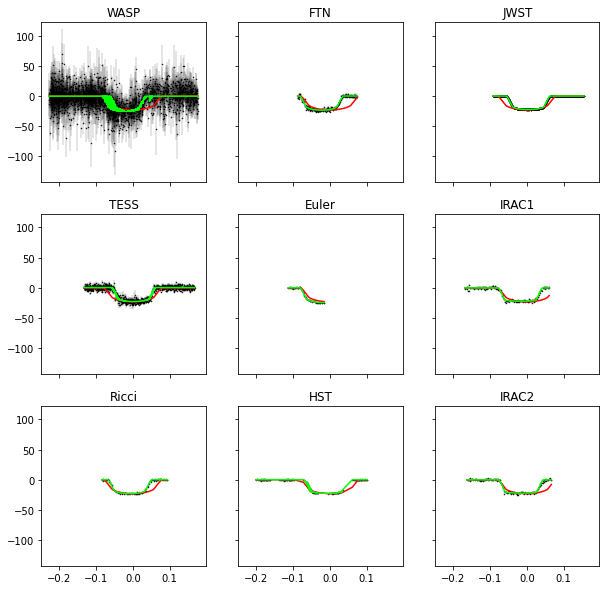

In [28]:
l0 = pmx.eval_in_model(lc_models, model=model, point=model.test_point)
l = pmx.eval_in_model(lc_models, model=model, point=map_soln)

fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=True, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    s = np.argsort(ph)
    ax[idx, jdx].errorbar(ph, y, yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1, zorder=-1)
    ax[idx, jdx].plot(ph[s], l0[name][s], c='r', zorder=10)
    ax[idx, jdx].plot(ph[s], l[name][s], c='lime', zorder=10)
    ax[idx, jdx].set(title=name)

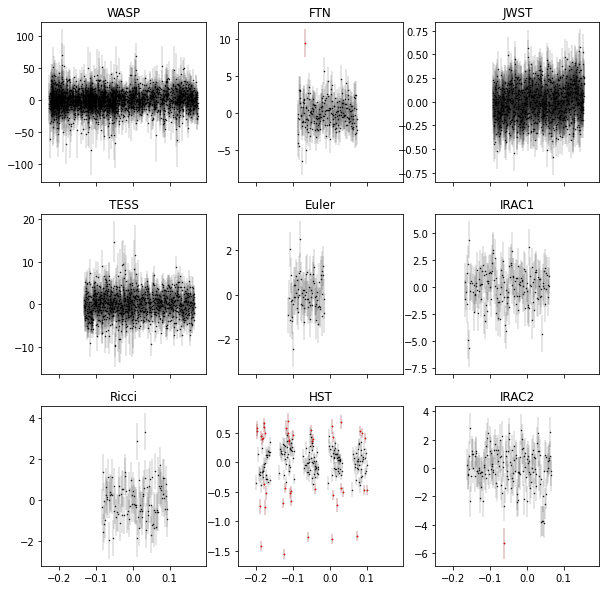

In [29]:
l0 = pmx.eval_in_model(lc_models, model=model, point=model.test_point)
l = pmx.eval_in_model(lc_models, model=model, point=map_soln)

fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=False, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    s = np.argsort(ph)
    ax[idx, jdx].errorbar(ph, y - l[name], yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1, zorder=-1)
    k = np.abs(y - l[name])/yerr > 4
    ax[idx, jdx].errorbar(ph[k], (y - l[name])[k], yerr[k], ls='', label=name, lw=0.2, c='r', marker='.', ms=1, zorder=-1)

    ax[idx, jdx].set(title=name)

# Sample

Which breaks horribly. Will not break if we remove some of the data.

In [31]:
np.random.seed(230948)
with model:
    trace = pmx.sample(
        tune=500,
        draws=500,
        start=map_soln,
        cores=4,
        chains=4,
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [IRAC2_sigma, IRAC2_log_approx_depth, IRAC2_u, IRAC2_mean, IRAC1_sigma, IRAC1_log_approx_depth, IRAC1_u, IRAC1_mean, JWST_sigma, JWST_log_approx_depth, JWST_u, JWST_mean, HST_sigma, HST_log_approx_depth, HST_u, HST_mean, Euler_sigma, Euler_log_approx_depth, Euler_u, Euler_mean, FTN_sigma, FTN_log_approx_depth, FTN_u, FTN_mean, Ricci_sigma, Ricci_log_approx_depth, Ricci_u, Ricci_mean, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, WASP_sigma, WASP_log_approx_depth, WASP_u, WASP_mean, tts, b, r_star, m_star]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 175 seconds.
The acceptance probability does not match the target. It is 0.9969789670668275, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9908184453618953, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.992997063011552, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9917496927145207, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
map_soln

{'m_star_interval__': array(-0.79090966),
 'r_star_interval__': array(-0.80795029),
 'b_interval__': array([-0.17047226]),
 'tts_interval__': array([-6.60147543e-01,  4.20536238e-06,  3.27578714e-05, -8.91060360e-06,
        -1.46219316e-05, -9.62913200e-01, -1.06206260e+00, -1.03675792e+00,
        -1.13012132e+00, -8.89171111e-01, -1.79437109e-05, -1.03754424e+00,
        -7.82497216e-01, -1.24385975e-01, -8.37263786e-01,  5.42658738e-06,
         4.90641235e-06, -4.73497604e-01, -1.99943587e-01, -9.64168804e-01,
         3.42941522e-06, -1.89731931e-01, -9.92095704e-01,  3.08065523e-06,
        -9.95432087e-01, -6.58158185e-02, -9.35065993e-01, -9.06948082e-01,
        -7.17175316e-01, -6.44977203e-01, -3.34979582e-01, -4.33697060e-01,
        -2.44794104e-01, -3.98102152e-01,  6.39774251e-03,  4.77585167e-02,
         1.43892609e-01,  1.33993373e-01,  1.11482864e-01,  1.59163399e-01]),
 'WASP_mean': array(-0.37570409),
 'WASP_u_quadlimbdark__': array([-0.5158736 ,  0.10747772]),
 '

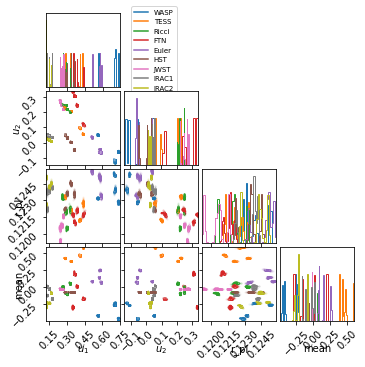

In [35]:
fig = plt.figure(figsize=(5, 5))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    corner.corner(
        trace,
        var_names=[f"{name}_u", f"{name}_r_pl", f'{name}_mean'], color=f'C{n}', fig=fig, labels=["$u_1$", "$u_2$", "r_pl", 'mean']);
    fig.axes[0].axvline(-1.0, color=f"C{n}", label=name)
_ = fig.axes[0].legend(
    fontsize=7, loc="center left", bbox_to_anchor=(1.1, 0.5)
)

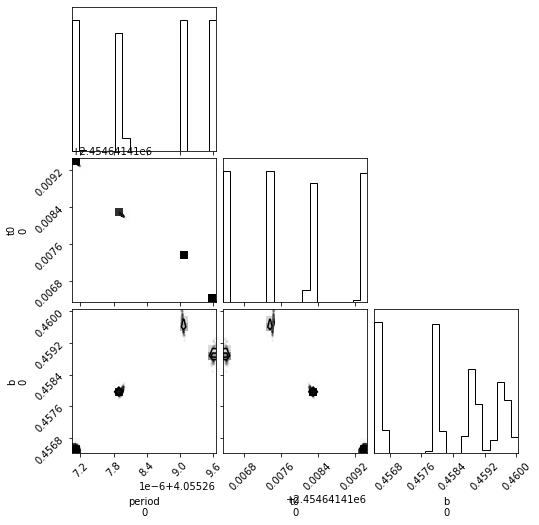

In [36]:
corner.corner(trace, var_names=['period', 't0', 'b']);

In [37]:
trace_period = np.vstack(trace.posterior['period']).mean(axis=0)[0]
trace_t0 = np.vstack(trace.posterior['t0']).mean(axis=0)[0]

Text(0.5, 0, 'Transit Time [days]')

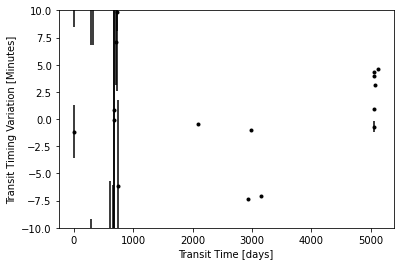

In [38]:
tt1 = np.asarray(transit_inds_est) * trace_period + trace_t0
x, y, ye = tt1, np.vstack(trace['posterior']['tts'] + transit_times_est).mean(axis=0) - tt1, np.vstack(trace['posterior']['tts'] + transit_times_est).std(axis=0)
plt.errorbar((x - x[0]), y*24*60, ye*24*60, ls='', marker='.', c='k')
plt.ylim(-10, 10)
plt.ylabel('Transit Timing Variation [Minutes]')
plt.xlabel("Transit Time [days]")